## Imports

In [1]:
%matplotlib inline
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import timedelta
import math
import sys

## Load Data

In [96]:
# Read the data from pickle file
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)

## Explore and Visualize Data

In [97]:
X.shape, y.shape

((746, 100, 100, 1), (746, 1))

In [100]:
# Let's check the data types - TensorFlow requires float32 and/or int32
X.dtype, y.dtype

(dtype('float32'), dtype('int32'))

In [99]:
X = X.astype('float32')

In [71]:
print("The Memory size of the data = {} KBs".format(int(sys.getsizeof(X))))

The Memory size of the data = 29840144 KBs


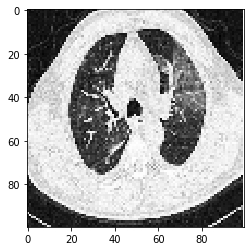

In [72]:
_ = plt.imshow(X[1].reshape(100, 100), cmap='gray')
plt.show()

## Data Dimensions

In [38]:
# We know that MNIST images are 28 pixels by 28 pixels
img_size = 100

# Images are stored in one-dimensional arrays of this length - number of numbers in the matrix of size 28 x 28
img_size_flat = img_size*img_size

# Height and width of each image in Tuple
img_shape = (img_size, img_size)

# Number of color channels for the image: 1 channel for gray-scale
num_channels = 1

# Number of classes, one class for each of 10 digits
num_classes = 2

## Hyperparameters of Neural Network

In [39]:
# Convolutional layer 1
filter1_size = 5  #Convolution filters are 5 x 5 pixels
num_filters1 = 16 #There are 16 of these filters

# Convolutional layer 2
filter2_size = 5 #Convolution filters are 5 x 5 pixels
num_filters2 = 32 #There are 32 of these filters

# Pooling
window_size = 2 #Pooling window 2x2
window_stride = 2 #Move by 2 strides

# Fully-connected layer
fc_size=128     # Number of nodes in the fully-connected layer

# Convolution stride
conv_stride=1

## Helper function for Creating Weights

In [73]:
def weights(shape):
    weights = tf.Variable(tf.random.normal(shape=shape, stddev=0.05))
    return weights

## ConvNet1

In [74]:
shape_1 = [filter1_size, filter1_size, num_channels, num_filters1]
shape_bias1 = [num_channels, img_size, img_size, num_filters1]
conv1_weights = weights(shape_1)
bias_1 = tf.Variable(tf.ones(shape=shape_bias1))

In [75]:
def ConvNet1(image):
    # Conv1 layer
    conv1 = tf.nn.conv2d(input=image, filters=conv1_weights, strides=conv_stride, padding='SAME')
    conv1+=bias_1
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(input=conv1, ksize=window_size, strides=window_stride, padding='SAME')
    return conv1

## ConvNet2

In [78]:
shape_2 = [filter2_size, filter2_size, num_filters1, num_filters2]
shape_bias2 = [num_channels, img_size//2, img_size//2, num_filters2]
conv2_weights = weights(shape_2)
bias_2 = tf.Variable(tf.ones(shape=shape_bias2))

In [79]:
def ConvNet2(conv1):
    # Conv2 Layer
    conv2 = tf.nn.conv2d(input=conv1, filters=conv2_weights, strides=conv_stride, padding='SAME')
    conv2+=bias_2
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(input=conv2, ksize=window_size, strides=window_stride, padding='SAME')
    return conv2

## Flatten Layer

In [82]:
def flatten_layer(conv2):
    layer_shape = conv2.get_shape()
    num_features = layer_shape[1:4].num_elements()
    flat_layer = tf.reshape(conv2, [-1, num_features])
    return flat_layer, num_features

## Fully Connected Layer

In [85]:
# Fully connected layer
num_features=20000 
fc_shape = [num_features, fc_size]
fc_weights = tf.Variable(tf.random.normal(shape=fc_shape))
bias_fc = tf.Variable(tf.ones([fc_size]))
# Output layer
shape_out = [fc_size, num_classes]
w_out = tf.Variable(tf.random.normal(shape=shape_out))
b_out = tf.Variable(tf.ones([num_classes]))

In [86]:
def make_prediction(flat_layer, fc_weights, bias_fc, w_out, b_out):
    #Fully connected layer
    fc_product = tf.matmul(flat_layer, fc_weights)
    fully_connected = tf.keras.activations.relu(fc_product+bias_fc)
    # Output layer
    output = tf.matmul(fully_connected, w_out)
    prediction = tf.keras.activations.softmax(output + b_out)
    return prediction

In [87]:
def model(image):
    conv1 = ConvNet1(image)
    conv2 = ConvNet2(conv1)
    flat_layer, num_features = flatten_layer(conv2)
    predictions = make_prediction(flat_layer, fc_weights, bias_fc, w_out, b_out)
    return predictions

## Compile and Train the Model

In [88]:
optimizer = tf.keras.optimizers.Adam()

In [89]:
# Instantiate a loss function.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [90]:
# Prepare the metrics.
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [91]:
# Package the data into batches
batch_size=16
train_ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(1024).batch(batch_size)

In [93]:
import time

start = time.time()
epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, [conv1_weights, bias_1, conv2_weights, bias_2, fc_weights, bias_fc, w_out, b_out])

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, [conv1_weights, bias_1, conv2_weights, bias_2, fc_weights, bias_fc, w_out, b_out]))
        
        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)

        # Log every 1874 batches.
        if step%16 == 0 and step!=0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * 32))
            
         # Display metrics at the end of every 1874 batch
        if step%16==0 and step!=0:
            train_acc = train_acc_metric.result()
            print("Training acc: %.4f" % (float(train_acc),))

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()

        # Run a validation loop at the end of each epoch.
        #for x_batch_val, y_batch_val in val_dataset:
        #    val_logits = model(x_batch_val)
            # Update val metrics
        #    val_acc_metric.update_state(y_batch_val, val_logits)
        #val_acc = val_acc_metric.result()
        #val_acc_metric.reset_states()
        #print("Validation acc: %.4f" % (float(val_acc),))
print("Time taken: %.2fs" % (time.time() - start))  


Start of epoch 0
Training loss (for one batch) at step 16: 0.6883
Seen so far: 544 samples
Training acc: 0.6250
Training loss (for one batch) at step 32: 0.8133
Seen so far: 1056 samples
Training acc: 0.5000

Start of epoch 1
Training loss (for one batch) at step 16: 0.8133
Seen so far: 544 samples
Training acc: 0.5000
Training loss (for one batch) at step 32: 0.7508
Seen so far: 1056 samples
Training acc: 0.5625
Time taken: 7.77s
